<span style="font-size: 20px;">**Import all Libraries**</span>


In [5]:
import pandas as pd
import numpy as np
import nltk 
import stanza
import re
import matplotlib.pyplot as plt
import joblib
import string
import pickle
from datetime import datetime
from sklearn.preprocessing import MultiLabelBinarizer
from indicnlp.tokenize import indic_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from nltk.tokenize import word_tokenize
nltk.download('punkt')

C:\Users\91981\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91981\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

<span style="font-size: 20px;">**CSV file import**</span>


In [6]:
file_path = r"C:\Personal\Minor Project\ML\BBC_Scrapped_news.csv"

# Load dataset
news_data = pd.read_csv(file_path)

print("File loaded successfully!")
print(news_data.head())  # Display first few rows


File loaded successfully!
                                                 URL       MatchDateTime  \
0  https://archive.org/details/BBCNEWS_20170131_0...   1/31/2017 5:53:28   
1  https://archive.org/details/BBCNEWS_20170118_1...  1/18/2017 19:21:01   
2  https://archive.org/details/BBCNEWS_20170105_2...    05-01-2017 21:48   
3  https://archive.org/details/BBCNEWS_20170105_2...    05-01-2017 21:13   
4  https://archive.org/details/BBCNEWS_20170111_0...    11-01-2017 03:11   

   Station            Show                                IAShowID  \
0  BBCNEWS        BBC News        BBCNEWS_20170131_054500_BBC_News   
1  BBCNEWS        BBC News        BBCNEWS_20170118_190000_BBC_News   
2  BBCNEWS  Outside Source  BBCNEWS_20170105_213000_Outside_Source   
3  BBCNEWS  Outside Source  BBCNEWS_20170105_210000_Outside_Source   
4  BBCNEWS        BBC News        BBCNEWS_20170111_030000_BBC_News   

                                      IAPreviewThumb  \
0  https://archive.org/download/BBCNEWS_

<span style="font-size: 20px;">**1. Data Exploration**</span>

<span style="font-size: 16px;">**a. Cleaning Junk**</span>

In [7]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22682 entries, 0 to 22681
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   URL             22682 non-null  object
 1   MatchDateTime   22682 non-null  object
 2   Station         22682 non-null  object
 3   Show            22678 non-null  object
 4   IAShowID        22682 non-null  object
 5   IAPreviewThumb  22682 non-null  object
 6   Snippet         22682 non-null  object
dtypes: object(7)
memory usage: 1.2+ MB


In [8]:
news_data.isnull().sum()

URL               0
MatchDateTime     0
Station           0
Show              4
IAShowID          0
IAPreviewThumb    0
Snippet           0
dtype: int64

In [9]:
news_data.duplicated().sum()

np.int64(0)

In [10]:
news_data.drop_duplicates

<bound method DataFrame.drop_duplicates of                                                      URL       MatchDateTime  \
0      https://archive.org/details/BBCNEWS_20170131_0...   1/31/2017 5:53:28   
1      https://archive.org/details/BBCNEWS_20170118_1...  1/18/2017 19:21:01   
2      https://archive.org/details/BBCNEWS_20170105_2...    05-01-2017 21:48   
3      https://archive.org/details/BBCNEWS_20170105_2...    05-01-2017 21:13   
4      https://archive.org/details/BBCNEWS_20170111_0...    11-01-2017 03:11   
...                                                  ...                 ...   
22677  https://archive.org/details/BBCNEWS_20200103_0...    03-01-2020 01:32   
22678  https://archive.org/details/BBCNEWS_20200114_0...   1/14/2020 0:52:14   
22679  https://archive.org/details/BBCNEWS_20200117_1...  1/17/2020 11:31:45   
22680  https://archive.org/details/BBCNEWS_20200116_0...   1/16/2020 5:17:15   
22681  https://archive.org/details/BBCNEWS_20200121_2...  1/21/2020 22:43:59 

<span style="font-size: 16px;">**b. Removing extra colomns**</span>

In [11]:
print(news_data.columns)

Index(['URL', 'MatchDateTime', 'Station', 'Show', 'IAShowID', 'IAPreviewThumb',
       'Snippet'],
      dtype='object')


In [12]:
news_data.drop(["URL", "Station", "Show", "IAShowID"], axis=1, inplace=True)

<span style="font-size: 16px;">**c. Fixing date format**</span>

In [13]:
# Function to convert the date format
def convert_date(date_string):
    try:
        # Try parsing the date in the expected format with time included
        date_obj = datetime.strptime(date_string, "%m/%d/%Y %H:%M:%S")
        # Convert to required format: DD-MM-YY
        return date_obj.strftime("%d-%m-%y")
    except ValueError:
        # If format does not match, return the original string
        return date_string

# Apply conversion to MatchDateTime column
news_data["MatchDateTime"] = news_data["MatchDateTime"].astype(str).apply(convert_date)

# Print to check
print(news_data["MatchDateTime"])

print("Date conversion complete. File updated successfully.")


0                31-01-17
1                18-01-17
2        05-01-2017 21:48
3        05-01-2017 21:13
4        11-01-2017 03:11
               ...       
22677    03-01-2020 01:32
22678            14-01-20
22679            17-01-20
22680            16-01-20
22681            21-01-20
Name: MatchDateTime, Length: 22682, dtype: object
Date conversion complete. File updated successfully.


In [14]:
news_data

,MatchDateTime,IAPreviewThumb,Snippet
0,31-01-17,https://archive.org/download/BBCNEWS_20170131_...,beena part to do. the airline industry has not...
1,18-01-17,https://archive.org/download/BBCNEWS_20170118_...,"it's beaten it by about 0.1, 0.12 degrees cels..."
2,05-01-2017 21:48,https://archive.org/download/BBCNEWS_20170105_...,"contact more than expected, how. your co nta c..."
3,05-01-2017 21:13,https://archive.org/download/BBCNEWS_20170105_...,"where every time a marketplace is closed down,..."
4,11-01-2017 03:11,https://archive.org/download/BBCNEWS_20170111_...,"applause climate change, a controversial issue..."
...,...,...,...
22677,03-01-2020 01:32,https://archive.org/download/BBCNEWS_20200103_...,risk of bushfire season such as this one but h...
22678,14-01-20,https://archive.org/download/BBCNEWS_20200114_...,"at the royal academy, with the seawater, an ex..."
22679,17-01-20,https://archive.org/download/BBCNEWS_20200117_...,activists outside aberdeen yesterday. still re...
22680,16-01-20,https://archive.org/download/BBCNEWS_20200116_...,theice is new research says the melting of the...


<span style="font-size: 20px;">**2. Feature selection**</span>

<span style="font-size: 16px;">**a. Tokenization, Stopword removal, Stemming/Lemmatization**</span>

In [15]:
# Load stopwords (you might need to run: nltk.download('stopwords'))
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str):
        return ""  # Ensure input is a string
    
    text = text.lower()  # Convert to lowercase
    
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'\b\d{1,5}\b', '', text)  # Remove small numbers (e.g., "2023" remains, but "25" is removed)
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation but keep spaces
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    
    return ' '.join(words)

# Apply cleaning to the dataset
news_data['Cleaned_Snippet'] = news_data['Snippet'].astype(str).apply(clean_text)


In [16]:
"""#Stemming
#used to remove redundant words to one word eg:[loved,loving, love] converted to love
ps = PorterStemmer() #this is an object

#every feature redundancy removal function
def stem(text):
    y = []

    for i in text.split():
        y.append(ps.stem(i))
    return " ".join(y)

#checking function
ps.stem('acting')

news_data['Cleaned_Snippet'] = news_data['Snippet'].astype(str).apply(stem)
news_data['Cleaned_Snippet'] = news_data['Cleaned_Snippet'].astype(str).apply(lambda x: x.split())"""

'#Stemming\n#used to remove redundant words to one word eg:[loved,loving, love] converted to love\nps = PorterStemmer() #this is an object\n\n#every feature redundancy removal function\ndef stem(text):\n    y = []\n\n    for i in text.split():\n        y.append(ps.stem(i))\n    return " ".join(y)\n\n#checking function\nps.stem(\'acting\')\n\nnews_data[\'Cleaned_Snippet\'] = news_data[\'Snippet\'].astype(str).apply(stem)\nnews_data[\'Cleaned_Snippet\'] = news_data[\'Cleaned_Snippet\'].astype(str).apply(lambda x: x.split())'

In [17]:
# Function to remove stopwords
def remove_stopwords(text):
    if pd.isnull(text):  # Handle missing values
        return ""

    words = text.split()  # Split text into words
    filtered_words = [word for word in words if word.lower() not in stop_words]  # Remove stopwords
    return " ".join(filtered_words)  # Join words back

news_data['Cleaned_Snippet'] = news_data['Cleaned_Snippet'].astype(str).apply(remove_stopwords)

# Display cleaned data
print(news_data[['Cleaned_Snippet']].head())


                                     Cleaned_Snippet
0  beena part airline industry part move reduce c...
1  beaten degrees celsius doesnt seem like lot te...
2  contact expected co nta ct le ns expected cont...
3  every time marketplace closed another appears ...
4  applause climate change controversial issue se...


<span style="font-size: 16px;">**b. Vectorization**</span>

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    stop_words='english', 
    max_features=4000, 
    max_df=0.85, 
    min_df=2, 
    ngram_range=(1,2)  # Unigrams + Bigrams
)

news_data['Cleaned_Snippet'] = news_data['Cleaned_Snippet'].astype(str)


X = vectorizer.fit_transform(news_data['Cleaned_Snippet'])

# Print first 50 words to check if numbers are removed
print(X.toarray())


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [19]:
# Save the trained TF-IDF vectorizer
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

print("TF-IDF Vectorizer saved successfully!")


TF-IDF Vectorizer saved successfully!


In [20]:
print(vectorizer.get_feature_names_out()[:1000])


['ability' 'able' 'absolute' 'absolutely' 'absorb' 'accelerate'
 'accelerating' 'accept' 'accepted' 'accepting' 'access' 'accord'
 'accord climate' 'according' 'according climate' 'according new'
 'account' 'accused' 'accusing' 'achieve' 'achieved' 'acknowledge'
 'acknowledged' 'acres' 'act' 'act climate' 'acting' 'action'
 'action climate' 'action collapse' 'action needed' 'action tackle'
 'action taken' 'actions' 'active' 'activism' 'activist' 'activist greta'
 'activists' 'activists arrested' 'activities' 'activity' 'actress' 'acts'
 'actual' 'actually' 'actually real' 'adapt' 'adaptation' 'adapting' 'add'
 'added' 'adding' 'additional' 'address' 'address climate' 'addressed'
 'addressing' 'addressing climate' 'administration' 'administrations'
 'admitted' 'adopted' 'adults' 'advice' 'adviser' 'advisers' 'advises'
 'advises government' 'advisors' 'affairs' 'affect' 'affected'
 'affected climate' 'affecting' 'affects' 'afford' 'afraid' 'africa'
 'african' 'afternoon' 'afternoon live'

<span style="font-size: 20px;">**3. Categorization on the basis of SDG of exsisting data**</span>

In [21]:
# SDG keyword dictionary
sdg_category = {
    "No Poverty": [
        "poverty", "low income", "economic disparity", "financial inclusion", "unemployment",
        "homelessness", "economic development", "social protection", "income inequality",
        "debt", "welfare programs", "job crisis", "food insecurity", "social safety nets",
        "microfinance", "living standards", "basic needs", "poor", "income", "economy", "financial"
    ],
    "Zero Hunger": [
        "hunger", "malnutrition", "food security", "undernourishment", "famine",
        "sustainable agriculture", "food waste", "nutrition programs", "child malnutrition",
        "agricultural production", "food distribution", "global hunger index", "farming policy", 
        "drought", "food scarcity", "agribusiness", "crop failure",  "food", "farmer", "agriculture"
    ],
    "Good Health and Well-being": [
        "health", "disease", "mental health", "pandemic", "malaria", "vaccination",
        "HIV/AIDS", "child mortality", "healthcare", "hospital", "medical facilities",
        "disease control", "diabetes", "heart disease", "hygiene", "physical fitness",
        "health insurance", "public health", "epidemic prevention", "death", "heat", "medicine", "lifestyle", "epidemic", "famine"
    ],
    "Quality Education": [
        "education", "school", "university", "learning", "literacy", "education policy",
        "e-learning", "technical education", "inclusive education", "higher education", "STEM education",
        "curriculum reform", "education reform", "free education", "teacher training", "online learning",
        "student engagement"
    ],
    "Gender Equality": [
        "gender discrimination", "women empowerment", "women's rights", "gender equality",
        "domestic violence", "female education", "feminism", "gender pay gap", "LGBTQ+ rights",
        "equal opportunities", "women leadership", "gender-based violence", "justice", "gender", "women", "girl", "sexual", "trafficking", "maternity", "reproductive", "discrimination"
    ],
    "Clean Water and Sanitation": [
        "water", "sanitation", "clean drinking water", "water scarcity", "waterborne diseases",
        "water conservation", "river pollution", "sewage treatment", "wastewater management", "water policies",
        "clean water access", "hygiene practices", "flood management"
    ],
    "Affordable and Clean Energy": [
        "renewable energy", "solar power", "wind energy", "biofuels", "energy efficiency",
        "solar panels", "electricity access", "green energy", "coal energy", "hydropower",
        "energy transition", "nuclear energy", "carbon neutrality"
    ],
    "Decent Work and Economic Growth": [
        "employment", "jobs", "wages", "worker rights", "job security", "youth unemployment",
        "startups", "business growth", "technology innovation", "standard of living",
        "entrepreneurship", "labor laws", "economic policy"
    ],
    "Industry, Innovation and Infrastructure": [
        "industry", "technology", "infrastructure", "transport", "innovation", "startups",
        "industrialization", "digital technology", "public transport", "smart cities",
        "telecommunications", "manufacturing", "engineering advancements", "automation",
        "AI and robotics", "research and development", "sustainable infrastructure",
        "digital transformation", "logistics", "supply chain management", "fintech",
        "blockchain technology", "transportation networks", "smart factories",
        "renewable materials", "green buildings", "infrastructure resilience",
        "cloud computing", "5G technology", "energy grids", "space exploration"
    ],
    "Reduced Inequality": [
        "inequality", "wealth disparity", "social inclusion", "economic equality",
        "ethnic discrimination", "racial discrimination", "disability rights",
        "social justice", "equal access", "income redistribution", "affirmative action",
        "social mobility", "economic inclusion", "minority rights", "refugee rights",
        "equal pay", "disability inclusion", "indigenous rights", "anti-discrimination laws",
        "inclusive policies", "gender identity rights", "economic justice", "access to healthcare",
        "educational equity", "financial accessibility", "social cohesion", "wealth redistribution",
        "empowerment programs", "age discrimination"
    ],
    "Sustainable Cities and Communities": [
        "sustainable urbanization", "environmental impact", "smart cities", "public transport",
        "green spaces", "affordable housing", "urban planning", "climate resilience",
        "eco-friendly buildings", "waste management", "carbon emissions"
    ],
    "Responsible Consumption and Production": [
        "sustainable production", "waste management", "recycling", "eco-friendly", "food waste",
        "sustainable practices", "consumption management", "circular economy", "plastic pollution",
        "ethical sourcing", "supply chain sustainability"
    ],
    "Climate Action": [
        "carbon emissions", "air pollution", "greenhouse gases",
        "deforestation",  "carbon footprint",
        "climate mitigation", "climate adaptation", "ice", "co2", "climate policy", "global warming"
    ],
    "Life Below Water": [
        "marine pollution", "ocean conservation", "fishing regulation", "coral reef protection", 
        "marine biodiversity", "overfishing", "plastic waste", "marine ecosystems", "ocean acidification", "ocean", "marine", "plastic pollution", "rising sea", "fishing", "coral", "sea"
    ],
    "Life on Land": [
        "wildlife conservation", "biodiversity", "deforestation", "environmental crisis", 
        "terrestrial ecosystem", "forest protection", "species loss", "habitat destruction",
        "soil degradation", "afforestation", "deforestation", "endangered", "poaching", "national park", "soil erosion", "desert", "organic farming", "wildfire", "forest", "species", "habitat", "conservation"
    ],
    "Peace, Justice and Strong Institutions": [
        "peace", "justice","corruption", "crime prevention", "law enforcement", "governance", "human rights",
        "judicial reform", "public security", "democracy", "civil liberties", "rule of law",
        "access to justice", "fair trials", "political stability", "legal system reform",
        "human trafficking", "police accountability", "war crimes", "cybercrime",
        "whistleblower protection", "press freedom", "digital rights", "prison reform",
        "conflict resolution", "peace treaties", "authoritarianism", "civic engagement",
        "judicial independence", "global warming", "environmental conservation", "accountability", "ceasefire", "conflict", "crime", "criminal", "democratic", "justice", "law", "legal", "peace", "privacy", "transparency", "violence", "war"
    ],
    "Partnerships for the Goals": [
        "partnerships", "global cooperation", "policy making", "United Nations", "funding",
        "international relations", "multilateralism", "foreign aid", "development partnerships", "collaboration", "initiatives", "fair trade", "trade agreement", "carbon offset", "ngo", "volunteer"
    ]
}
sdg_list = list(sdg_category.keys())  # List of SDG categories


In [22]:
def categorize_news_article(article):
    """
    Categorize a news article based on SDG keywords.
    :param article: str, input news article text
    :return: list, SDG categories assigned
    """
    """if pd.isna(article):  # Handle missing values
        return ["Uncategorized"]"""
    
    article = article.lower()  # Convert to lowercase for case-insensitive matching
    matched_sdgs = []

    for sdg, keywords in sdg_category.items():
        for keyword in keywords:
            if re.search(rf'\b{re.escape(keyword)}\b', article):  # Word-boundary matching
                matched_sdgs.append(sdg)
                break  # Stop checking after the first match for this SDG

    return matched_sdgs if matched_sdgs else ["Uncategorized"]

news_data["SDG_Category"] = news_data["Cleaned_Snippet"].apply(categorize_news_article)

# Convert list to a comma-separated string for better readability
news_data["SDG_Category"] = news_data["SDG_Category"].apply(lambda x: ", ".join(x))

# Display first few rows
print(news_data[["Cleaned_Snippet", "SDG_Category"]].head())

                                     Cleaned_Snippet  \
0  beena part airline industry part move reduce c...   
1  beaten degrees celsius doesnt seem like lot te...   
2  contact expected co nta ct le ns expected cont...   
3  every time marketplace closed another appears ...   
4  applause climate change controversial issue se...   

                                        SDG_Category  
0  Industry, Innovation and Infrastructure, Clima...  
1                   Climate Action, Life Below Water  
2  Climate Action, Peace, Justice and Strong Inst...  
3  Climate Action, Peace, Justice and Strong Inst...  
4                                      Uncategorized  


In [23]:
# Define the SDG mapping
sdg_mapping = {
    "No Poverty": 1,
    "Zero Hunger": 2,
    "Good Health and Well-being": 3,
    "Quality Education": 4,
    "Gender Equality": 5,
    "Clean Water and Sanitation": 6,
    "Affordable and Clean Energy": 7,
    "Decent Work and Economic Growth": 8,
    "Industry, Innovation and Infrastructure": 9,
    "Reduced Inequality": 10,
    "Sustainable Cities and Communities": 11,
    "Responsible Consumption and Production": 12,
    "Climate Action": 13,
    "Life Below Water": 14,
    "Life on Land": 15,
    "Peace, Justice and Strong Institutions": 16,
    "Partnerships for the Goals": 17,
}

# Initialize a dictionary to store counts
sdg_counts = {sdg: 0 for sdg in sdg_mapping.keys()}

# Count occurrences of each SDG in the dataset
for categories in news_data["SDG_Category"]:
    if categories in sdg_counts:  # **Keep original case**
        sdg_counts[categories] += 1  # Update count

# Print the counts
for sdg, count in sdg_counts.items():
    print(f"{sdg}: {count}")


No Poverty: 433
Zero Hunger: 319
Good Health and Well-being: 428
Quality Education: 353
Gender Equality: 116
Clean Water and Sanitation: 237
Affordable and Clean Energy: 123
Decent Work and Economic Growth: 84
Industry, Innovation and Infrastructure: 401
Reduced Inequality: 36
Sustainable Cities and Communities: 9
Responsible Consumption and Production: 6
Climate Action: 796
Life Below Water: 427
Life on Land: 297
Peace, Justice and Strong Institutions: 490
Partnerships for the Goals: 57


In [24]:
# ✅ Function to clean and map SDG category names
def get_sdg_number(category):
    if category is None or (isinstance(category, int) and category == 0):  
        return None  # Handle None or 0 values

    if isinstance(category, (list, np.ndarray)):  # If category is a list/array, take the first element
        category = category[0] if len(category) > 0 else None

    if category is None:
        return None  # If category is still None after list/array processing
    
    # Convert to title case to match dictionary keys
    category = str(category).strip().replace("\n", "").replace("\t", "")
    
    # Handle multiple categories in a string
    categories = [c.strip() for c in category.split(",")]
    
    # Get SDG numbers for all categories in the list
    sdg_numbers = [sdg_mapping.get(c, 0) for c in categories]  # Default to 0 if not found
    
    return sdg_numbers if len(sdg_numbers) > 1 else sdg_numbers[0]  # Return list if multiple, else int

# ✅ Apply function to create 'SDG_nbr' column
news_data["SDG_nbr"] = news_data["SDG_Category"].apply(get_sdg_number)

# ✅ Check results
print(news_data[["SDG_Category", "SDG_nbr"]].head(20))


                                         SDG_Category            SDG_nbr
0   Industry, Innovation and Infrastructure, Clima...         [0, 0, 13]
1                    Climate Action, Life Below Water           [13, 14]
2   Climate Action, Peace, Justice and Strong Inst...         [13, 0, 0]
3   Climate Action, Peace, Justice and Strong Inst...         [13, 0, 0]
4                                       Uncategorized                  0
5                                       Uncategorized                  0
6                                       Uncategorized                  0
7   Climate Action, Peace, Justice and Strong Inst...         [13, 0, 0]
8   Climate Action, Peace, Justice and Strong Inst...         [13, 0, 0]
9   Climate Action, Peace, Justice and Strong Inst...         [13, 0, 0]
10  Climate Action, Peace, Justice and Strong Inst...         [13, 0, 0]
11                                      Uncategorized                  0
12  Climate Action, Life on Land, Peace, Justice a.

In [25]:
news_data

,MatchDateTime,IAPreviewThumb,Snippet,Cleaned_Snippet,SDG_Category,SDG_nbr
0,31-01-17,https://archive.org/download/BBCNEWS_20170131_...,beena part to do. the airline industry has not...,beena part airline industry part move reduce c...,"Industry, Innovation and Infrastructure, Clima...","[0, 0, 13]"
1,18-01-17,https://archive.org/download/BBCNEWS_20170118_...,"it's beaten it by about 0.1, 0.12 degrees cels...",beaten degrees celsius doesnt seem like lot te...,"Climate Action, Life Below Water","[13, 14]"
2,05-01-2017 21:48,https://archive.org/download/BBCNEWS_20170105_...,"contact more than expected, how. your co nta c...",contact expected co nta ct le ns expected cont...,"Climate Action, Peace, Justice and Strong Inst...","[13, 0, 0]"
3,05-01-2017 21:13,https://archive.org/download/BBCNEWS_20170105_...,"where every time a marketplace is closed down,...",every time marketplace closed another appears ...,"Climate Action, Peace, Justice and Strong Inst...","[13, 0, 0]"
4,11-01-2017 03:11,https://archive.org/download/BBCNEWS_20170111_...,"applause climate change, a controversial issue...",applause climate change controversial issue se...,Uncategorized,0
...,...,...,...,...,...,...
22677,03-01-2020 01:32,https://archive.org/download/BBCNEWS_20200103_...,risk of bushfire season such as this one but h...,risk bushfire season one argues australia keep...,No Poverty,1
22678,14-01-20,https://archive.org/download/BBCNEWS_20200114_...,"at the royal academy, with the seawater, an ex...",royal academy seawater expanse seawater put ex...,Life Below Water,14
22679,17-01-20,https://archive.org/download/BBCNEWS_20200117_...,activists outside aberdeen yesterday. still re...,activists outside aberdeen yesterday still rea...,Uncategorized,0
22680,16-01-20,https://archive.org/download/BBCNEWS_20200116_...,theice is new research says the melting of the...,theice new research says melting ice sheets ac...,Climate Action,13


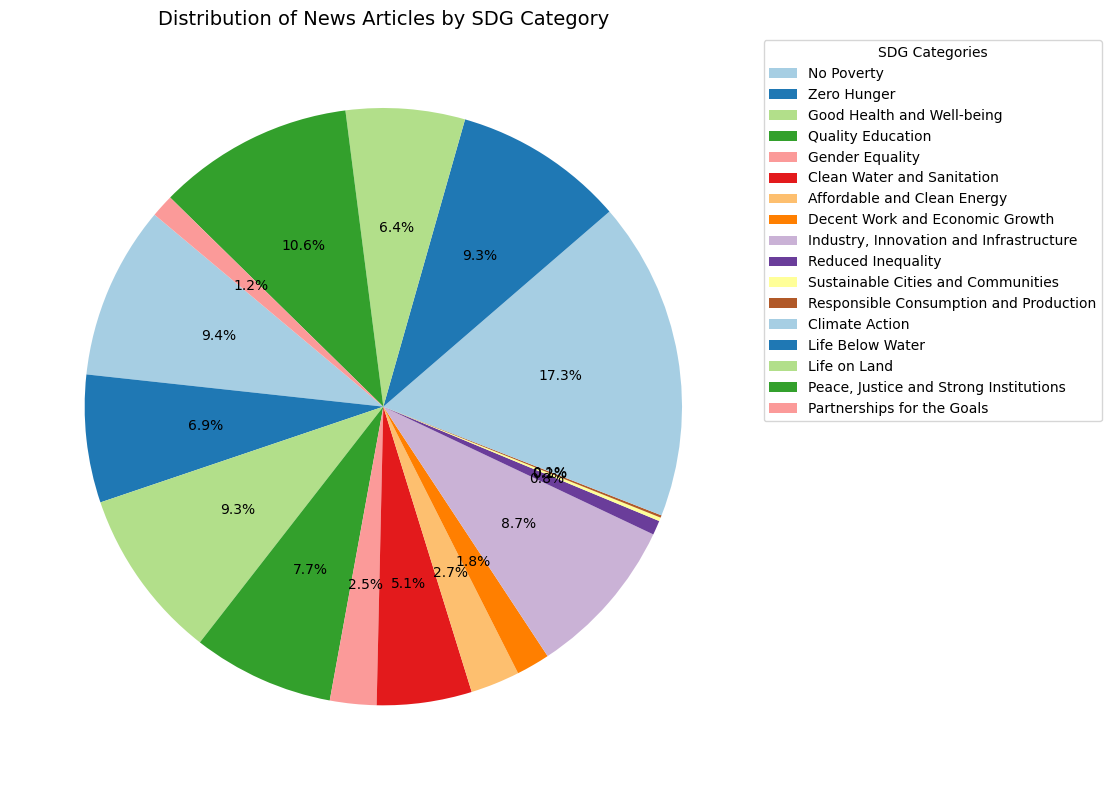

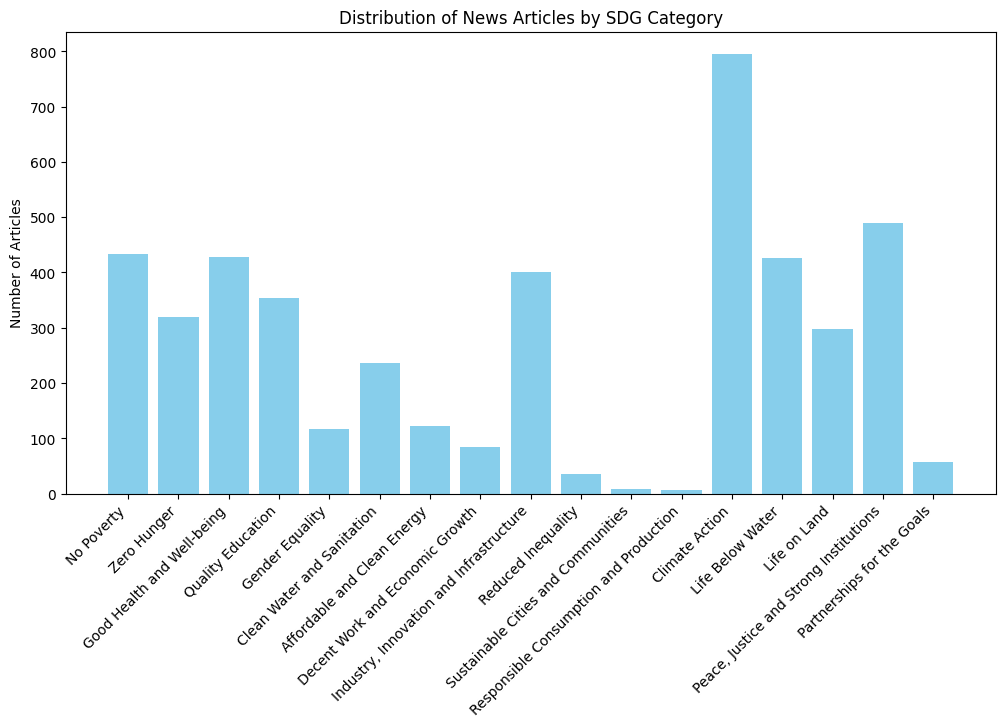

In [26]:
# Define all 17 SDGs
sdg_list_2 = [
    "no poverty", "zero hunger", "good health and well-being", "quality education", "gender equality",
    "clean water and sanitation", "affordable and clean energy", "decent work and economic growth",
    "industry, innovation, and infrastructure", "reduced inequalities", "sustainable cities and communities",
    "responsible consumption and production", "climate action", "life below water", "life on land",
    "peace, justice, and strong institutions", "partnerships for the goals", "uncategorized"
]

# Count occurrences of each SDG category in news data
sdg_counts = news_data["SDG_Category"].explode().value_counts()

# Ensure all 17 SDGs are included, even if they have 0 count
sdg_data = {sdg: sdg_counts.get(sdg, 0.1) for sdg in sdg_list}  # Use 0.1 instead of 0

### 📌 Pie Chart: Adjusted Counts to Ensure All SDGs Appear ###
plt.figure(figsize=(12, 8))
wedges, texts, autotexts = plt.pie(
    sdg_data.values(),
    labels=None,  # Remove direct labels
    autopct="%1.1f%%",
    startangle=140,
    colors=plt.cm.Paired.colors,
    textprops={'fontsize': 10}
)

# Add a legend instead of direct labels
plt.legend(wedges, sdg_data.keys(), title="SDG Categories", loc="upper left", bbox_to_anchor=(1, 1))

plt.title("Distribution of News Articles by SDG Category", fontsize=14)
plt.tight_layout()  # Ensure proper spacing
plt.show()

### 📌 Bar Chart: Better Representation for Uneven Distributions ###
plt.figure(figsize=(12, 6))
plt.bar(sdg_data.keys(), sdg_data.values(), color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Articles")
plt.title("Distribution of News Articles by SDG Category")
plt.show()

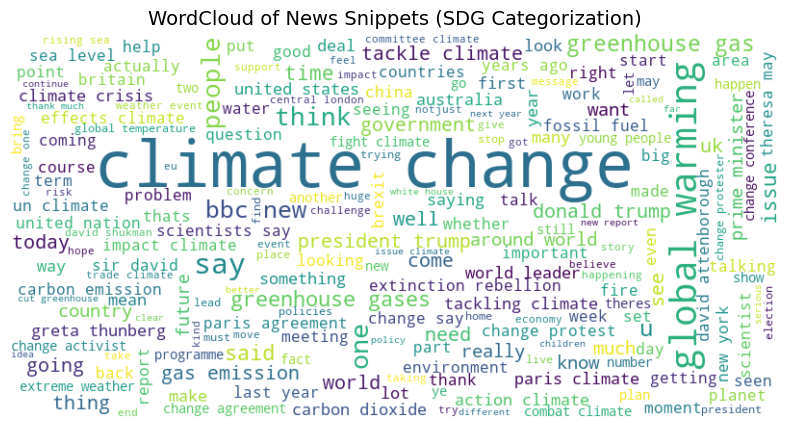

In [27]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Combine all text for WordCloud
text_data = " ".join(news_data["Cleaned_Snippet"])

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(text_data)

# Plot WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.title("WordCloud of News Snippets (SDG Categorization)", fontsize=14)
plt.show()

In [28]:
news_data[100:110]

,MatchDateTime,IAPreviewThumb,Snippet,Cleaned_Snippet,SDG_Category,SDG_nbr
100,05-01-2017 21:13,https://archive.org/download/BBCNEWS_20170105_...,often stated that the speed of global warming ...,often stated speed global warming slowing new ...,"Climate Action, Peace, Justice and Strong Inst...","[13, 0, 0]"
101,10-01-2017 03:29,https://archive.org/download/BBCNEWS_20170110_...,of huge hydro-electric dams. it argues the pro...,huge hydroelectric dams argues project boost e...,"No Poverty, Climate Action, Life on Land, Peac...","[1, 13, 15, 0, 0]"
102,02-01-2017 06:50,https://archive.org/download/BBCNEWS_20170102_...,"during his campaign, he said this is what he w...",campaign said would going cancel paris climate...,"Climate Action, Peace, Justice and Strong Inst...","[13, 0, 0]"
103,05-01-2017 21:46,https://archive.org/download/BBCNEWS_20170105_...,have new information on global warming this ce...,new information global warming century many sc...,"Climate Action, Peace, Justice and Strong Inst...","[13, 0, 0]"
104,18-01-17,https://archive.org/download/BBCNEWS_20170118_...,redouble their commitment to the paris climate...,redouble commitment paris climate change agree...,Uncategorized,0
105,10-01-2017 00:06,https://archive.org/download/BBCNEWS_20170110_...,"meanwhile, in italy there are christmas card s...",meanwhile italy christmas card sent little eve...,"Climate Action, Peace, Justice and Strong Inst...","[13, 0, 0]"
106,10-01-2017 03:16,https://archive.org/download/BBCNEWS_20170110_...,deforestation and global warming. wyre davies ...,deforestation global warming wyre davies visit...,"Climate Action, Life on Land, Peace, Justice a...","[13, 15, 0, 0]"
107,05-01-2017 21:48,https://archive.org/download/BBCNEWS_20170105_...,question over a whole bunch of global warming ...,question whole bunch global warming data colle...,"Climate Action, Life Below Water, Peace, Justi...","[13, 14, 0, 0]"
108,20-01-17,https://archive.org/download/BBCNEWS_20170120_...,international treaty on global warming and he ...,international treaty global warming wreck trea...,"Climate Action, Peace, Justice and Strong Inst...","[13, 0, 0]"
109,16-01-17,https://archive.org/download/BBCNEWS_20170116_...,but environmentalists say the plans are a disa...,environmentalists say plans disaster amazon re...,"Climate Action, Life on Land, Peace, Justice a...","[13, 15, 0, 0]"


In [29]:
# ✅ Function to find SDG category based on heading or content
def get_sdg_from_text(news_data, search_text):      

    # Find matches in both heading and content using case-insensitive search
    matches = news_data[
        news_data["Cleaned_Snippet"].str.contains(search_text, case=False, na=False)
    ]
    
    if matches.empty:
        return "No matching news articles found."
    
    # Return the SDG category for the first matching entry
    return matches.iloc[0][["SDG_Category", "SDG_nbr"]]

# ✅ Ask user for input and find SDG category
news_text = input("Enter a news heading or content snippet: ")
sdg_category_number = get_sdg_from_text(news_data, news_text)

# ✅ Print the SDG category
print(f"SDG Goal for the given text:\n{sdg_category_number}")


SDG Goal for the given text:
No matching news articles found.


In [30]:
# ✅ Ask user for SDG goal number
sdg_goal_number = input("Enter an SDG goal number: ").strip()

# ✅ Filter news articles for the given SDG goal
filtered_news = news_data[news_data["SDG_nbr"].astype(str) == sdg_goal_number]

# ✅ Print the results
if filtered_news.empty:
    print(f"⚠️ No news articles found for SDG Goal {sdg_goal_number}.")
else:
    print(f"\n📢 Top {len(filtered_news)} news articles for SDG Goal {sdg_goal_number}:\n")

    # ✅ Iterate over rows correctly using `iterrows()`
    for idx, (_, news) in enumerate(filtered_news.iterrows(), start=1):
        print(f"News {idx}:")
        print(f"Date      : {news["MatchDateTime"]}")
        print(f"Heading   : {news['Snippet']}")
        print(f"Content   : {news['SDG_Category']}")  # Display first 100 chars
        print(f"SDG Goal  : {news['SDG_nbr']}")


📢 Top 319 news articles for SDG Goal 2:

News 1:
Date      : 01-01-2017 12:49
Heading   : with climate change and there may also be a link with competition from fisheries, as in humans obtaining the same food, krill, as these penguins would normally eat. scientists say only by tracking these birds will we see how they fare in this changing world.
Content   : Zero Hunger
SDG Goal  : 2
News 2:
Date      : 22-02-17
Heading   : have just got to accept? so many governments, wars, climate change? can we do more to stop this happening again? we have got a lot of drought happening across africa. and africa does experience drought.
Content   : Zero Hunger
SDG Goal  : 2
News 3:
Date      : 14-05-17
Heading   : embarrassed about this. in many communities, acute malnutrition is being staved off by hand-outs. campaigners say climate change is here to stay,
Content   : Zero Hunger
SDG Goal  : 2
News 4:
Date      : 14-05-17
Heading   : dying for a lack of food, it isn't visible, there aren't picture

<span style="font-size: 20px;">**4. Applying Different ML models**</span>

In [31]:
# Load dataset (Ensure news_data is defined before using it)
X = news_data["Cleaned_Snippet"]  # News text
y = news_data["SDG_Category"]  # Target labels

# Apply TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=4000)  # Convert text to numerical format
X_tfidf = vectorizer.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=100),
    "SVM": SVC(kernel="linear", probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Naïve Bayes": MultinomialNB()
}

# Train and evaluate models
results = {}
trained_models = {}  # Dictionary to store trained models

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    results[name] = acc
    trained_models[name] = model  # Store trained model
    
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

# Select best-performing model
best_model_name = max(results, key=results.get)
best_model = trained_models[best_model_name]  # Get actual model object

print(f"\nBest performing model: {best_model_name} with Accuracy: {results[best_model_name]:.4f}")


Logistic Regression Accuracy: 0.8021
                                                                                                                                         precision    recall  f1-score   support

                                                                                                            Affordable and Clean Energy       0.62      0.18      0.28        28
                                                                                            Affordable and Clean Energy, Climate Action       0.00      0.00      0.00         1
                                                    Affordable and Clean Energy, Climate Action, Peace, Justice and Strong Institutions       0.00      0.00      0.00         3
                                                                   Affordable and Clean Energy, Industry, Innovation and Infrastructure       0.00      0.00      0.00         4
               Affordable and Clean Energy, Industry, Innovation and Infrast

C:\Users\91981\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\91981\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\91981\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i


SVM Accuracy: 0.9167
                                                                                                                                         precision    recall  f1-score   support

                                                                                                            Affordable and Clean Energy       0.58      0.54      0.56        28
                                                                                            Affordable and Clean Energy, Climate Action       1.00      1.00      1.00         1
                                                    Affordable and Clean Energy, Climate Action, Peace, Justice and Strong Institutions       0.50      0.33      0.40         3
                                                                   Affordable and Clean Energy, Industry, Innovation and Infrastructure       1.00      0.25      0.40         4
               Affordable and Clean Energy, Industry, Innovation and Infrastructure, Sustain

C:\Users\91981\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\91981\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\91981\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(


Random Forest Accuracy: 0.9365
                                                                                                                                         precision    recall  f1-score   support

                                                                                                            Affordable and Clean Energy       0.83      0.54      0.65        28
                                                                                            Affordable and Clean Energy, Climate Action       1.00      1.00      1.00         1
                                                    Affordable and Clean Energy, Climate Action, Peace, Justice and Strong Institutions       1.00      0.67      0.80         3
                                                                   Affordable and Clean Energy, Industry, Innovation and Infrastructure       1.00      0.25      0.40         4
               Affordable and Clean Energy, Industry, Innovation and Infrastructur

C:\Users\91981\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\91981\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\91981\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(


Naïve Bayes Accuracy: 0.6531
                                                                                                                                         precision    recall  f1-score   support

                                                                                                            Affordable and Clean Energy       1.00      0.04      0.07        28
                                                                                            Affordable and Clean Energy, Climate Action       0.00      0.00      0.00         1
                                                    Affordable and Clean Energy, Climate Action, Peace, Justice and Strong Institutions       0.00      0.00      0.00         3
                                                                   Affordable and Clean Energy, Industry, Innovation and Infrastructure       0.00      0.00      0.00         4
               Affordable and Clean Energy, Industry, Innovation and Infrastructure,

C:\Users\91981\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\91981\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\91981\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

<span style="font-size: 20px;">**5. Deploy & Categorize New News Articles using Random Forests**</span>

In [32]:
with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [33]:
with open("random_forest_model.pkl", "rb") as f:
    best_model = pickle.load(f)

print(type(best_model))  # Should print <class 'sklearn.ensemble._forest.RandomForestClassifier'>


<class 'sklearn.ensemble._forest.RandomForestClassifier'>


In [34]:
import re
import pandas as pd
from nltk.tokenize import word_tokenize

# Function to preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)
    return " ".join(tokens)

# Function to categorize new news articles
def categorize_news_articles(news_data):
    if isinstance(news_data, list):  # If input is a list
        cleaned_texts = [preprocess_text(text.lower()) for text in news_data]  
    elif isinstance(news_data, pd.DataFrame):  # If input is a DataFrame
        cleaned_texts = [preprocess_text(text.lower()) for text in news_data["Cleaned_Snippet"]]
    else:
        raise TypeError("Input must be a list or pandas DataFrame.")

    # Transform text using the same TF-IDF vectorizer
    tfidf_vectors = vectorizer.transform(cleaned_texts)
    predictions = best_model.predict(tfidf_vectors)

    # Return predictions as a list
    return predictions

# Example: Predict SDG category for new articles
new_articles = [
    "climate adaptation is causing rising sea levels, affecting coastal cities.",
    ""
]

predicted_categories = categorize_news_articles(new_articles)

# Display results
for article, category in zip(new_articles, predicted_categories):
    print(f"Article: {article}\nPredicted SDG Category: {category}\n")


Article: climate adaptation is causing rising sea levels, affecting coastal cities.
Predicted SDG Category: Life Below Water

Article: 
Predicted SDG Category: Uncategorized

